## E21CSEU0068 JAHNVI SAHNI

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pyspark.sql import SparkSession
from pyspark import SparkContext
from pyspark.sql import functions as F
from graphframes import GraphFrame


In [ ]:
from pyspark.sql import SparkSession

graphframes_jar_path = '/usr/local/lib/python3.10/dist-packages/pyspark/jars/graphframes-0.8.4-spark3.5-s_2.12.jar'

# Create Spark session with the graphframes JAR
spark = SparkSession.builder \
    .appName("FlightGraphAnalysis") \
    .config("spark.jars", graphframes_jar_path) \
    .config("spark.submit.pyFiles", graphframes_jar_path) \
    .getOrCreate()

In [ ]:
data = spark.read.csv("/traffic.csv", header=True, inferSchema=True)
data.show(5)

+-------------------+--------+--------+-----------+
|           DateTime|Junction|Vehicles|         ID|
+-------------------+--------+--------+-----------+
|2015-11-01 00:00:00|       1|      15|20151101001|
|2015-11-01 01:00:00|       1|      13|20151101011|
|2015-11-01 02:00:00|       1|      10|20151101021|
|2015-11-01 03:00:00|       1|       7|20151101031|
|2015-11-01 04:00:00|       1|       9|20151101041|
+-------------------+--------+--------+-----------+
only showing top 5 rows



#preprocessing

In [ ]:
from pyspark.ml.feature import Imputer

imputer = Imputer(inputCols=["Vehicles"], outputCols=["Vehicles_imputed"])
data_imputed = imputer.fit(data).transform(data)

# Or you can drop rows with missing values:
data_cleaned = data.dropna()

In [ ]:
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(inputCols=["Vehicles"], outputCol="features")
data_assembled = assembler.transform(data_imputed)

scaler = StandardScaler(inputCol="features", outputCol="scaled_features")
scaler_model = scaler.fit(data_assembled)
data_normalized = scaler_model.transform(data_assembled)

In [ ]:
from pyspark.sql.functions import col, to_timestamp

# Convert DateTime to Timestamp
data = data.withColumn("DateTime", to_timestamp("DateTime", "yyyy-MM-dd HH:mm:ss"))
data.show(5)

+-------------------+--------+--------+-----------+
|           DateTime|Junction|Vehicles|         ID|
+-------------------+--------+--------+-----------+
|2015-11-01 00:00:00|       1|      15|20151101001|
|2015-11-01 01:00:00|       1|      13|20151101011|
|2015-11-01 02:00:00|       1|      10|20151101021|
|2015-11-01 03:00:00|       1|       7|20151101031|
|2015-11-01 04:00:00|       1|       9|20151101041|
+-------------------+--------+--------+-----------+
only showing top 5 rows



In [ ]:
junctions = [1, 2, 3, 4]

# Create edges (fully connected graph with weights 1)
edges = []
for i in range(len(junctions)):
    for j in range(i + 1, len(junctions)):
        edges.append((junctions[i], junctions[j], 1.0))

# Create DataFrame for edges
edges_df = spark.createDataFrame(edges, ["src", "dst", "weight"])

# Create DataFrame for junctions (vertices)
vertices = spark.createDataFrame([(1, "Junction 1"), (2, "Junction 2"), (3, "Junction 3"), (4, "Junction 4")], ["id", "name"])

# Create GraphFrame
from graphframes import GraphFrame
g = GraphFrame(vertices, edges_df)

# Show the GraphFrame
g.vertices.show()
g.edges.show()

+---+----------+
| id|      name|
+---+----------+
|  1|Junction 1|
|  2|Junction 2|
|  3|Junction 3|
|  4|Junction 4|
+---+----------+

+---+---+------+
|src|dst|weight|
+---+---+------+
|  1|  2|   1.0|
|  1|  3|   1.0|
|  1|  4|   1.0|
|  2|  3|   1.0|
|  2|  4|   1.0|
|  3|  4|   1.0|
+---+---+------+



## Visualizing the data

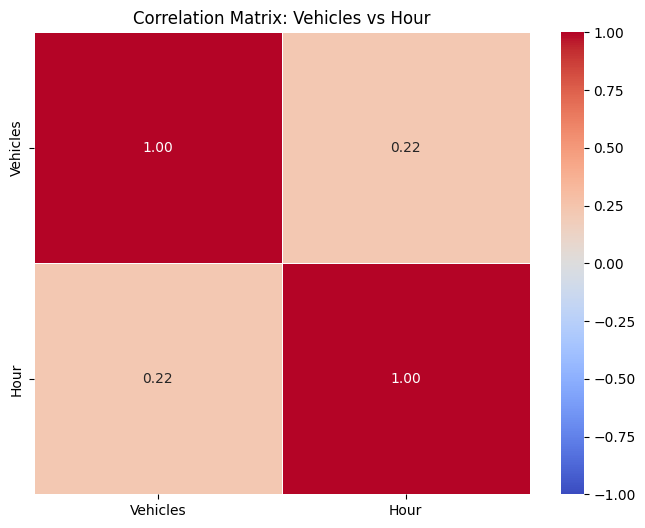

In [ ]:
from pyspark.sql.functions import hour
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

data_with_time_features = data_cleaned.withColumn("Hour", hour("DateTime"))
data_for_correlation = data_with_time_features.select("Vehicles", "Hour")

assembler = VectorAssembler(inputCols=["Vehicles", "Hour"], outputCol="features")
data_for_correlation_assembled = assembler.transform(data_for_correlation)
correlation_matrix = Correlation.corr(data_for_correlation_assembled, "features").head()[0]

correlation_matrix_array = correlation_matrix.toArray()

correlation_df = pd.DataFrame(correlation_matrix_array,
                              columns=["Vehicles", "Hour"],
                              index=["Vehicles", "Hour"])

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_df, annot=True, cmap="coolwarm", vmin=-1, vmax=1, fmt='.2f', linewidths=0.5)
plt.title("Correlation Matrix: Vehicles vs Hour")
plt.show()


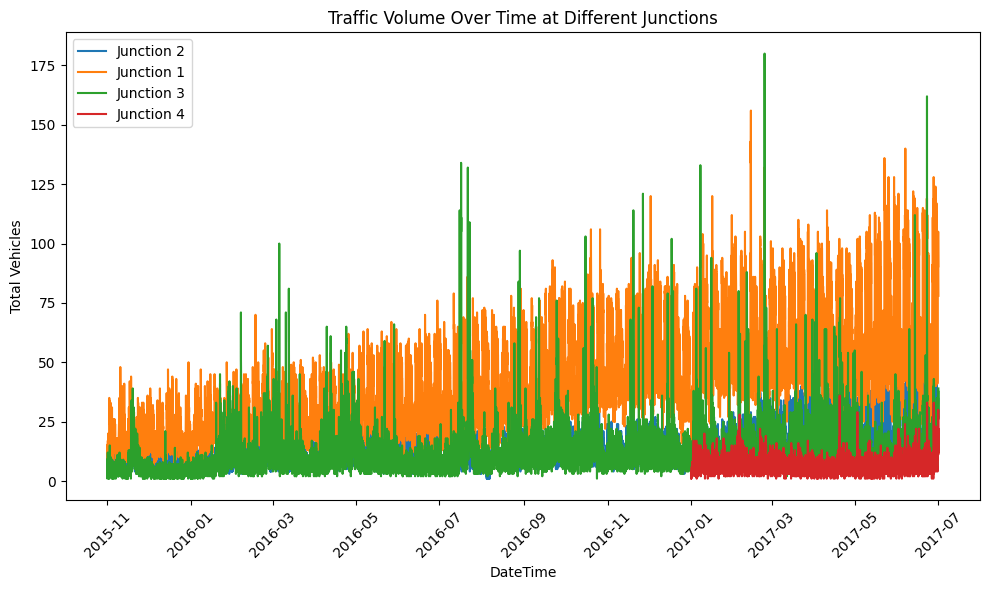

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql.functions import hour, dayofweek, month
data_with_time = data_cleaned.withColumn("Hour", hour("DateTime")) \
                             .withColumn("DayOfWeek", dayofweek("DateTime")) \
                             .withColumn("Month", month("DateTime"))
traffic_by_hour = data_with_time.groupBy("DateTime", "Junction").agg({"Vehicles": "sum"}) \
                                .withColumnRenamed("sum(Vehicles)", "Total_Vehicles") \
                                .orderBy("DateTime")

traffic_pandas = traffic_by_hour.toPandas()

plt.figure(figsize=(10, 6))
for junction in traffic_pandas['Junction'].unique():
    subset = traffic_pandas[traffic_pandas['Junction'] == junction]
    plt.plot(subset['DateTime'], subset['Total_Vehicles'], label=f'Junction {junction}')

plt.xlabel('DateTime')
plt.ylabel('Total Vehicles')
plt.title('Traffic Volume Over Time at Different Junctions')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


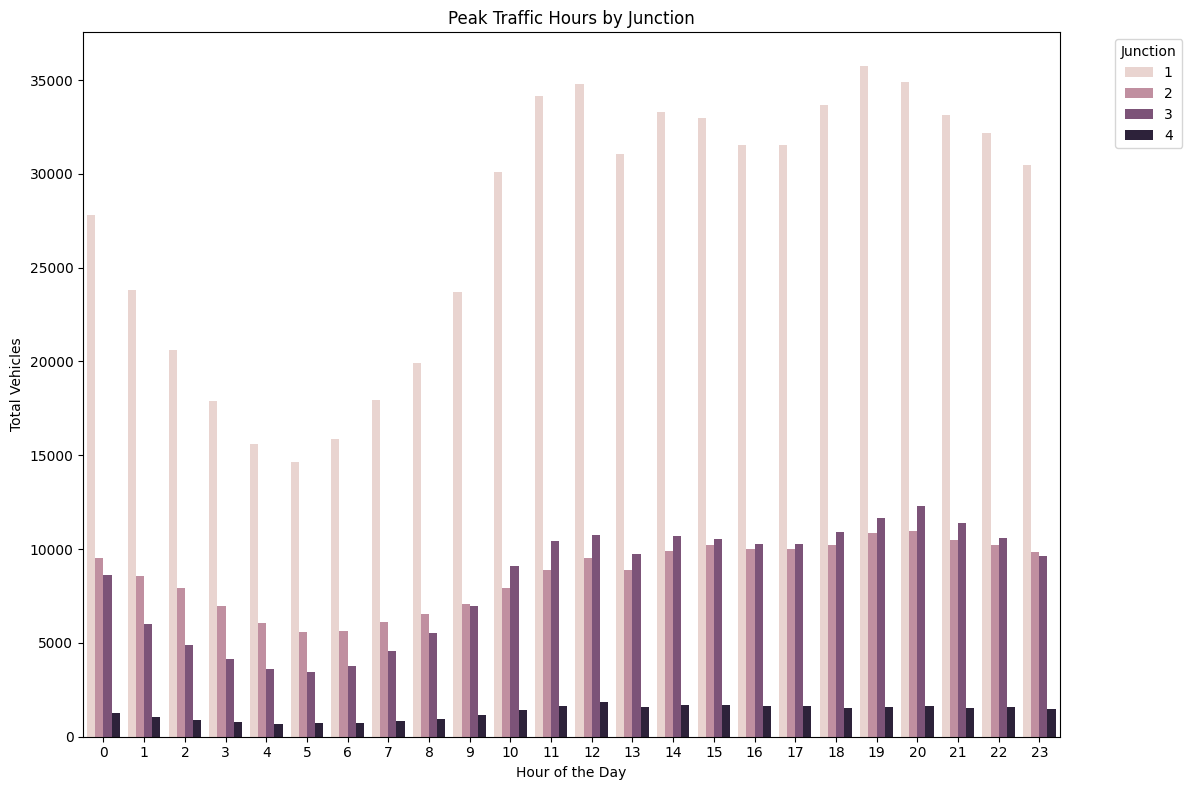

In [ ]:
traffic_by_junction_hour = data_with_time.groupBy("Junction", "Hour").agg({"Vehicles": "sum"}) \
                                         .withColumnRenamed("sum(Vehicles)", "Total_Vehicles")


traffic_by_junction_hour_df = traffic_by_junction_hour.toPandas()


plt.figure(figsize=(12, 8))
sns.barplot(data=traffic_by_junction_hour_df, x='Hour', y='Total_Vehicles', hue='Junction')
plt.title('Peak Traffic Hours by Junction')
plt.xlabel('Hour of the Day')
plt.ylabel('Total Vehicles')
plt.xticks(range(0, 24))
plt.legend(title='Junction', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


## Logistic Regression

In [ ]:
from pyspark.sql.window import Window
from pyspark.sql import functions as F

from pyspark.sql import functions as F

data_lagged = data_cleaned.withColumn("Vehicles_lagged", F.lag("Vehicles", 1).over(Window.partitionBy("Junction").orderBy("DateTime")))

data_lagged = data_lagged.dropna(subset=["Vehicles_lagged"])

assembler = VectorAssembler(inputCols=["Vehicles_lagged"], outputCol="features")
data_lagged = assembler.transform(data_lagged)
train_data, test_data = data_lagged.randomSplit([0.8, 0.2], seed=123)

from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(featuresCol="features", labelCol="Vehicles")
lr_model = lr.fit(train_data)
predictions = lr_model.transform(test_data)

predictions.select("DateTime", "Vehicles", "prediction").show(5)


+-------------------+--------+----------+
|           DateTime|Vehicles|prediction|
+-------------------+--------+----------+
|2015-11-01 01:00:00|       7|       9.0|
|2015-11-01 03:00:00|       7|       9.0|
|2015-11-01 05:00:00|       6|       9.0|
|2015-11-01 05:00:00|       2|       7.0|
|2015-11-01 07:00:00|       8|       9.0|
+-------------------+--------+----------+
only showing top 5 rows



In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import abs, col


evaluator_rmse = RegressionEvaluator(labelCol="Vehicles", predictionCol="prediction", metricName="rmse")
evaluator_mse = RegressionEvaluator(labelCol="Vehicles", predictionCol="prediction", metricName="mse")
evaluator_r2 = RegressionEvaluator(labelCol="Vehicles", predictionCol="prediction", metricName="r2")

rmse = evaluator_rmse.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE): {rmse}")

mse = evaluator_mse.evaluate(predictions)
print(f"Mean Squared Error (MSE): {mse}")
=
r2 = evaluator_r2.evaluate(predictions)
print(f"R2 (Coefficient of Determination): {r2}")


Root Mean Squared Error (RMSE): 5.1688516968256195
Mean Squared Error (MSE): 26.71702786377709
R2 (Coefficient of Determination): 0.9373195033067114


In [ ]:

mae = predictions.select(abs(col("Vehicles") - col("prediction")).alias("abs_error")).agg({"abs_error": "mean"}).collect()[0][0]
print(f"Mean Absolute Error (MAE): {mae}")


Mean Absolute Error (MAE): 3.404953560371517


In [ ]:

mape = predictions.select(
    (abs(col("Vehicles") - col("prediction")) / col("Vehicles")).alias("percentage_error")
).agg({"percentage_error": "mean"}).collect()[0][0]

print(f"Mean Absolute Percentage Error (MAPE): {mape * 100}%")


Mean Absolute Percentage Error (MAPE): 22.379585115763128%


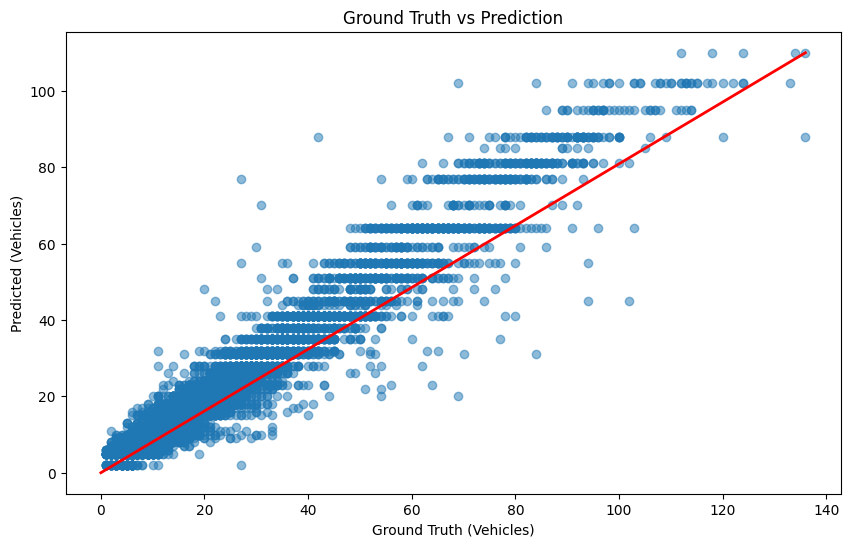

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

predictions_df = predictions.select("Vehicles", "prediction").toPandas()

plt.figure(figsize=(10, 6))
plt.scatter(predictions_df["Vehicles"], predictions_df["prediction"], alpha=0.5)
plt.plot([0, max(predictions_df["Vehicles"])], [0, max(predictions_df["prediction"])], color='red', lw=2)
plt.xlabel("Ground Truth (Vehicles)")
plt.ylabel("Predicted (Vehicles)")
plt.title("Ground Truth vs Prediction")
plt.show()


In [ ]:
threshold = 10

predictions_class = predictions.withColumn(
    "prediction_class",
    when(col("prediction") > threshold, 1).otherwise(0)
)

predictions_class = predictions_class.withColumn(
    "actual_class",
    when(col("Vehicles") > threshold, 1).otherwise(0)
)

predictions_class.select("Vehicles", "prediction", "prediction_class", "actual_class").show(5)

+--------+----------+----------------+------------+
|Vehicles|prediction|prediction_class|actual_class|
+--------+----------+----------------+------------+
|       7|       9.0|               0|           0|
|       7|       9.0|               0|           0|
|       6|       9.0|               0|           0|
|       2|       7.0|               0|           0|
|       8|       9.0|               0|           0|
+--------+----------+----------------+------------+
only showing top 5 rows



In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.classification import LogisticRegression

correct_predictions = predictions_class.filter(col("prediction_class") == col("actual_class")).count()
total_predictions = predictions_class.count()
accuracy = correct_predictions / total_predictions
print(f"Accuracy: {accuracy * 100:.2f}%")
tp = predictions_class.filter((col("prediction_class") == 1) & (col("actual_class") == 1)).count()
fp = predictions_class.filter((col("prediction_class") == 1) & (col("actual_class") == 0)).count()
tn = predictions_class.filter((col("prediction_class") == 0) & (col("actual_class") == 0)).count()
fn = predictions_class.filter((col("prediction_class") == 0) & (col("actual_class") == 1)).count()

precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1_score:.2f}")
evaluator_roc = BinaryClassificationEvaluator(labelCol="actual_class", rawPredictionCol="prediction")
roc_auc = evaluator_roc.evaluate(predictions_class)
print(f"ROC-AUC: {roc_auc:.2f}")


Accuracy: 89.51%
Precision: 0.95
Recall: 0.89
F1-Score: 0.92
ROC-AUC: 0.96


## K means

In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans
from pyspark.sql.functions import col, when
from pyspark.ml.evaluation import BinaryClassificationEvaluator
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
kmeans = KMeans(k=2, seed=1, featuresCol="features", predictionCol="cluster")
kmeans_model = kmeans.fit(data_lagged)
predictions = kmeans_model.transform(data_lagged)

In [ ]:
print(predictions)

DataFrame[DateTime: timestamp, Junction: int, Vehicles: int, ID: bigint, Vehicles_lagged: int, features: vector, cluster: int]


In [ ]:

predictions.show(5)


+-------------------+--------+--------+-----------+---------------+--------+-------+
|           DateTime|Junction|Vehicles|         ID|Vehicles_lagged|features|cluster|
+-------------------+--------+--------+-----------+---------------+--------+-------+
|2015-11-01 01:00:00|       1|      13|20151101011|             15|  [15.0]|      0|
|2015-11-01 02:00:00|       1|      10|20151101021|             13|  [13.0]|      0|
|2015-11-01 03:00:00|       1|       7|20151101031|             10|  [10.0]|      0|
|2015-11-01 04:00:00|       1|       9|20151101041|              7|   [7.0]|      0|
|2015-11-01 05:00:00|       1|       6|20151101051|              9|   [9.0]|      0|
+-------------------+--------+--------+-----------+---------------+--------+-------+
only showing top 5 rows



In [ ]:

threshold = 10


predictions_class1 = predictions.withColumn(
    "actual_class",
    when(col("Vehicles") > threshold, 1).otherwise(0)
)

predictions_class1 = predictions_class.withColumn(
    "prediction_class",
    when(col("cluster") == 1, 1).otherwise(0)
)

predictions_class1.select("DateTime", "Junction", "Vehicles", "cluster", "actual_class", "prediction_class").show(5)

+-------------------+--------+--------+-------+------------+----------------+
|           DateTime|Junction|Vehicles|cluster|actual_class|prediction_class|
+-------------------+--------+--------+-------+------------+----------------+
|2015-11-01 01:00:00|       1|      13|      0|           1|               0|
|2015-11-01 02:00:00|       1|      10|      0|           0|               0|
|2015-11-01 03:00:00|       1|       7|      0|           0|               0|
|2015-11-01 04:00:00|       1|       9|      0|           0|               0|
|2015-11-01 05:00:00|       1|       6|      0|           0|               0|
+-------------------+--------+--------+-------+------------+----------------+
only showing top 5 rows



In [ ]:
from pyspark.sql.functions import col
predictions_class1 = predictions_class.withColumn("prediction_class", col("prediction_class").cast("double"))

In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(labelCol="actual_class", predictionCol="prediction_class", metricName="accuracy")

accuracy = evaluator.evaluate(predictions_class1)
print(f"Accuracy: {accuracy}")

Accuracy: 0.5055906559148724


In [ ]:
evaluator_precision = MulticlassClassificationEvaluator(labelCol="actual_class", predictionCol="prediction_class", metricName="weightedPrecision")
precision = evaluator_precision.evaluate(predictions_class1)
print(f"Precision: {precision}")


evaluator_recall = MulticlassClassificationEvaluator(labelCol="actual_class", predictionCol="prediction_class", metricName="weightedRecall")
recall = evaluator_recall.evaluate(predictions_class1)
print(f"Recall: {recall}")

evaluator_f1 = MulticlassClassificationEvaluator(labelCol="actual_class", predictionCol="prediction_class", metricName="f1")
f1 = evaluator_f1.evaluate(predictions_class1)
print(f"F1-Score: {f1}")

Precision: 0.8035539190679415
Recall: 0.5055906559148724
F1-Score: 0.46903799549028224


In [ ]:
evaluator_auc = BinaryClassificationEvaluator(labelCol="actual_class", rawPredictionCol="prediction_class", metricName="areaUnderROC")

auc = evaluator_auc.evaluate(predictions_class1)
print(f"AUC: {auc}")


AUC: 0.6332480266403552


In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import abs, col

evaluator_rmse = RegressionEvaluator(labelCol="actual_class", predictionCol="prediction_class", metricName="rmse")
rmse = evaluator_rmse.evaluate(predictions_class1)
print(f"RMSE: {rmse}")

evaluator_mse = RegressionEvaluator(labelCol="actual_class", predictionCol="prediction_class", metricName="mse")
mse = evaluator_mse.evaluate(predictions_class1)
print(f"MSE: {mse}")

evaluator_r2 = RegressionEvaluator(labelCol="actual_class", predictionCol="prediction_class", metricName="r2")
r2 = evaluator_r2.evaluate(predictions_class1)
print(f"R²: {r2}")

predictions_class = predictions_class1.withColumn(
    "absolute_percentage_error", abs((col("actual_class") - col("prediction_class")) / col("actual_class"))
)

mape = predictions_class.agg({'absolute_percentage_error': 'avg'}).collect()[0][0] * 100
print(f"MAPE: {mape}%")


RMSE: 0.7031424777988652
MSE: 0.4944093440851276
R²: -1.250272628178101
MAPE: 73.35039467192897%


## Decision Tree

In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.evaluation import RegressionEvaluator

In [ ]:
dt_regressor = DecisionTreeRegressor(featuresCol="features", labelCol="Vehicles")

dt_model = dt_regressor.fit(train_data)

dt_predictions = dt_model.transform(test_data)

dt_predictions.select("Vehicles", "features", "prediction").show(5)

+--------+--------+-----------------+
|Vehicles|features|       prediction|
+--------+--------+-----------------+
|       7|   [9.0]| 8.62747723620782|
|       7|  [10.0]|10.42051282051282|
|       6|   [9.0]| 8.62747723620782|
|       2|   [7.0]| 6.82435170178282|
|       8|   [9.0]| 8.62747723620782|
+--------+--------+-----------------+
only showing top 5 rows



In [ ]:
evaluator_rmse = RegressionEvaluator(
    labelCol="Vehicles", predictionCol="prediction", metricName="rmse"
)
evaluator_mse = RegressionEvaluator(
    labelCol="Vehicles", predictionCol="prediction", metricName="mse"
)
evaluator_r2 = RegressionEvaluator(
    labelCol="Vehicles", predictionCol="prediction", metricName="r2"
)
evaluator_mae = RegressionEvaluator(
    labelCol="Vehicles", predictionCol="prediction", metricName="mae"
)

rmse = evaluator_rmse.evaluate(dt_predictions)
mse = evaluator_mse.evaluate(dt_predictions)
r2 = evaluator_r2.evaluate(dt_predictions)
mae = evaluator_mae.evaluate(dt_predictions)

print(f"Decision Tree Regression Metrics:")
print(f"RMSE: {rmse}")
print(f"MSE: {mse}")
print(f"R²: {r2}")
print(f"MAE: {mae}")

Decision Tree Regression Metrics:
RMSE: 5.37073852262336
MSE: 28.844832278390548
R²: 0.932327487044492
MAE: 3.5114626798648096


In [ ]:

threshold = 10
predictions_class12 = dt_predictions.withColumn(
    "actual_class",
    when(col("Vehicles") > threshold, 1).otherwise(0)
)

predictions_class12 = predictions_class12.withColumn(
    "prediction_class",
    when(col("prediction") > threshold, 1).otherwise(0)
)

predictions_class12.select("Vehicles", "features", "prediction", "actual_class", "prediction_class").show(5)

+--------+--------+-----------------+------------+----------------+
|Vehicles|features|       prediction|actual_class|prediction_class|
+--------+--------+-----------------+------------+----------------+
|       7|   [9.0]| 8.62747723620782|           0|               0|
|       7|  [10.0]|10.42051282051282|           0|               1|
|       6|   [9.0]| 8.62747723620782|           0|               0|
|       2|   [7.0]| 6.82435170178282|           0|               0|
|       8|   [9.0]| 8.62747723620782|           0|               0|
+--------+--------+-----------------+------------+----------------+
only showing top 5 rows



In [ ]:
from pyspark.sql.functions import col

predictions_class12 = predictions_class12.withColumn("prediction_class", col("prediction_class").cast("double"))

In [ ]:
evaluator_accuracy = MulticlassClassificationEvaluator(labelCol="actual_class", predictionCol="prediction_class", metricName="accuracy")
accuracy = evaluator_accuracy.evaluate(predictions_class12)
print(f"Accuracy: {accuracy}")

evaluator_precision = MulticlassClassificationEvaluator(labelCol="actual_class", predictionCol="prediction_class", metricName="weightedPrecision")
precision = evaluator_precision.evaluate(predictions_class12)
print(f"Precision: {precision}")

evaluator_recall = MulticlassClassificationEvaluator(labelCol="actual_class", predictionCol="prediction_class", metricName="weightedRecall")
recall = evaluator_recall.evaluate(predictions_class12)
print(f"Recall: {recall}")

evaluator_f1 = MulticlassClassificationEvaluator(labelCol="actual_class", predictionCol="prediction_class", metricName="f1")
f1 = evaluator_f1.evaluate(predictions_class12)
print(f"F1-Score: {f1}")

evaluator_auc = BinaryClassificationEvaluator(labelCol="actual_class", rawPredictionCol="prediction", metricName="areaUnderROC")
auc = evaluator_auc.evaluate(predictions_class12)
print(f"AUC: {auc}")

Accuracy: 0.8868937048503612
Precision: 0.8864475548857049
Recall: 0.8868937048503612
F1-Score: 0.8843612238655022
AUC: 0.9603727713209306


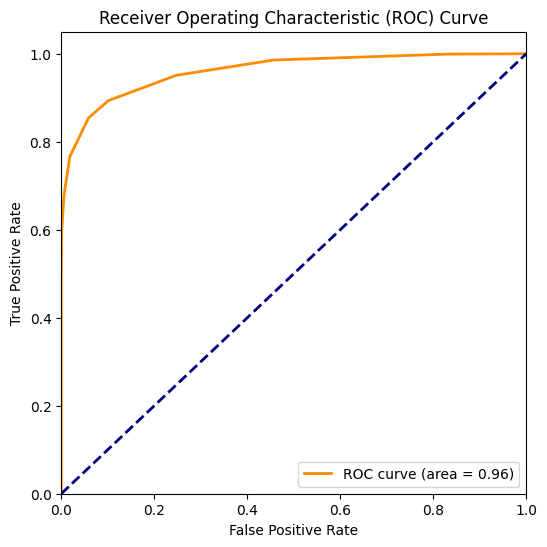

In [ ]:
evaluator = BinaryClassificationEvaluator(labelCol="actual_class", rawPredictionCol="prediction")
roc_auc = evaluator.evaluate(predictions_class12)

fpr, tpr, thresholds = roc_curve(predictions_class12.select("actual_class").rdd.flatMap(lambda x: x).collect(),
                                 predictions_class12.select("prediction").rdd.flatMap(lambda x: x).collect())
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()